In [15]:
import pandas as pd
import os
import random
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Python black formatter 적용
import pandas as pd
import numpy as np

import math
import time

from tqdm import tqdm

warnings.filterwarnings('ignore')

gc.enable()

## Kfold

In [32]:
import pandas as pd
import os
import random
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Python black formatter 적용
import math
import time

from tqdm import tqdm

warnings.filterwarnings('ignore')

gc.enable()
from sklearn.model_selection import KFold, TimeSeriesSplit

In [3]:
data_dir = '/opt/ml/input/data/' # 경로는 상황에 맞춰서 수정해주세요! # 데이터는 대회홈페이지에서 받아주세요 :)
csv_file_train_path = os.path.join(data_dir, 'train_after2.csv')
csv_file_test_path = os.path.join(data_dir, 'test_after2.csv') 

## ! 중요
## pre_train_df는 featur가 잘 만들어지는 테스트하고, 실제 적용은 df에 해야함
pre_train_df = pd.read_csv(csv_file_train_path, parse_dates=['Timestamp'], index_col=['Unnamed: 0'])
pre_test_df = pd.read_csv(csv_file_test_path, parse_dates=['Timestamp'], index_col=['Unnamed: 0'])

In [4]:
train = pre_train_df.copy(deep=True)
test = pre_test_df.copy(deep=True)

In [5]:
train = train.drop(columns = ["assessmentItemID", "Timestamp", "testId"])
target_df = test[test["answerCode"]==-1]

In [6]:
users = list(zip(train['userID'].value_counts().index, train['userID'].value_counts()))

In [227]:
train = pre_train_df.copy(deep=True)
test = pre_test_df.copy(deep=True)

train = train.drop(columns = ["assessmentItemID", "Timestamp", "testId"])
target_df = test[test["answerCode"]==-1]

users = list(zip(train['userID'].value_counts().index, train['userID'].value_counts()))

train = train.iloc[:,:]
col = list(train.columns.values)

del_suffix = ['assess','_o','_x','left_asymptote',
              'test',
              '_cum',
              'tag_acc', 
              'suffix'
              '_acc', 
              '_cum','_sum','_std','_median'
             'prefix_acc', 'suffix',
       # 'suffix_ans_mean', 'suffix_count', 'suffix_acc', 'weekday', 'month',
       'day', 'hour', 'weekday_ans_mean', 'month_ans_mean', 'day_ans_mean',
       'hour_ans_mean', 'elap_time', 'user_time_mean', 'user_time_median',
       'tag_time_mean', 'tag_time_median', 'prefix_time_mean',
       # 'prefix_time_median', 'suffix_time_mean', 'suffix_time_median',
       # 'user_relatvie_time', 'tag_relatvie_time', 'prefix_relatvie_time',
       # 'suffix_relatvie_time', 'total_used_time', 'recent3_elap_time',
       # 'total_count', 'tag_ans_mean', 'tag_count', 'tag_acc', 'prefix',
       # 'prefix_ans_mean', 'prefix_count', 'reset_time'
              # 'elo_prob'
             ]


col2 = col.copy()
for j in del_suffix:
    for i in col2:
        if j in i:
            try:del col[col.index(i)]
            except:pass

        
train = train.loc[:,col]
target_df = target_df.loc[:, col]
target_df = target_df.drop(columns=["answerCode"])
target_df.columns

Index(['userID', 'KnowledgeTag', 'elo_prob', 'user_acc', 'user_mean',
       'total_count', 'tag_ans_mean', 'tag_count', 'prefix', 'prefix_ans_mean',
       'prefix_count', 'prefix_acc', 'month', 'prefix_time_median',
       'user_relatvie_time', 'tag_relatvie_time', 'prefix_relatvie_time',
       'total_used_time', 'reset_time'],
      dtype='object')

In [228]:
target_df.columns.size

19

In [229]:
for col in train.columns:
    if not col in target_df.columns:
        print(col)

answerCode


In [231]:
from lightgbm import LGBMRegressor
from tqdm import tqdm

# kf = KFold(n_splits=10, shuffle=True, random_state=1)
kf = TimeSeriesSplit(n_splits=5)

cnt = 1
n_splits=5

y_pred = np.zeros(len(target_df))

for train_idx, valid_idx in kf.split(users):
    print(f'===================================  iter: {cnt}  ===================================\n')

    tr = train[train['userID'].isin(train_idx)]
    valid = train[train['userID'].isin(valid_idx)]
    valid = valid[valid['userID'] != valid['userID'].shift(-1)]

    X_train = tr.drop(['answerCode'], axis=1)
    y_train = tr['answerCode']
    X_valid = valid.drop(['answerCode'], axis=1)
    y_valid = valid['answerCode']


    lgbm = LGBMRegressor(n_estimators = 1000, learning_rate= 0.001, max_depth=9, min_child_weight=5, n_jobs=-1, random_state=1234)
    lgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric= 'auc', early_stopping_rounds= 50,verbose = 100)
    y_pred += lgbm.predict(target_df) / n_splits
    cnt+=1

# print("best AUC : ", max(bestAUC))
print('finish')

===================================  iter: 1  ===================================

[100]	valid_0's auc: 0.804741	valid_0's l2: 0.265374
[200]	valid_0's auc: 0.80622	valid_0's l2: 0.25119
[300]	valid_0's auc: 0.808311	valid_0's l2: 0.239335
[400]	valid_0's auc: 0.809395	valid_0's l2: 0.22943
[500]	valid_0's auc: 0.810682	valid_0's l2: 0.221138
[600]	valid_0's auc: 0.811241	valid_0's l2: 0.21423
===================================  iter: 2  ===================================

[100]	valid_0's auc: 0.813465	valid_0's l2: 0.26094
[200]	valid_0's auc: 0.816227	valid_0's l2: 0.246462
[300]	valid_0's auc: 0.818069	valid_0's l2: 0.234521
===================================  iter: 3  ===================================

[100]	valid_0's auc: 0.827832	valid_0's l2: 0.256768
[200]	valid_0's auc: 0.831687	valid_0's l2: 0.242236
[300]	valid_0's auc: 0.834449	valid_0's l2: 0.229979
[400]	valid_0's auc: 0.836114	valid_0's l2: 0.21969
[500]	valid_0's auc: 0.837343	valid_0's l2: 0.211081
[600]	valid_0's

In [232]:
lgbm.best_score_['valid_0']['auc']

0.8735698212474645

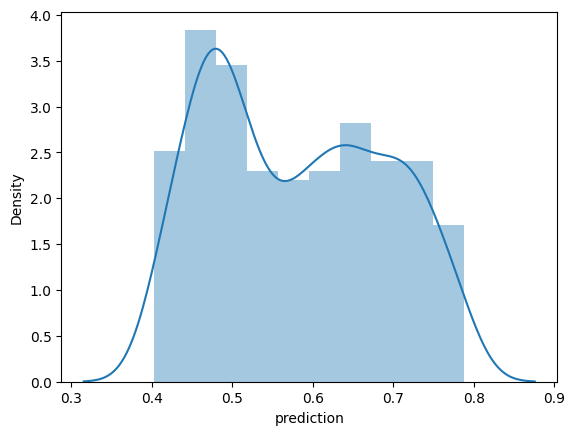

In [233]:
sample_submission = pd.read_csv("../data/sample_submission.csv")
reg_kf_submission = sample_submission.copy()
reg_kf_submission['prediction'] = y_pred

time = str(datetime.now(timezone('Asia/Seoul')).hour) + str.zfill(str(datetime.now(timezone('Asia/Seoul')).minute), 2)
sns.distplot(reg_kf_submission['prediction'])
plt.savefig("./"+time+".png")

In [234]:
reg_kf_submission.to_csv("./lgbm_" + time + ".csv")

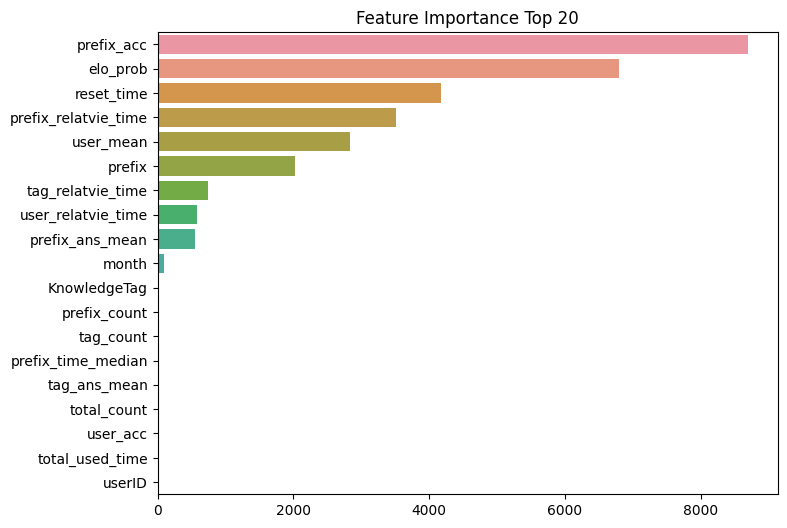

In [235]:
# 배열형태로 반환
ft_importance_values = lgbm.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [ ]:
low = reg_kf_submission[reg_kf_submission['prediction'] < 0.2]['id']
high = reg_kf_submission[reg_kf_submission['prediction'] > 0.8]['id']

us = 209

print("---------정답을 맞출 확률이 0.2 이하인 user의 평균 정답률---------")
for us in low:
    print(f"user [{us}] : ", train[train['userID'] == us]['answerCode'].sum() / train[train['userID'] == us]['answerCode'].size)
    
print()
print("---------정답을 맞출 확률이 0.8 이상인 user의 평균 정답률---------")
for us in high:
    print(f"user [{us}] : ", train[train['userID'] == us]['answerCode'].sum() / train[train['userID'] == us]['answerCode'].size)